# Diabetes Prediction – End-to-End ML Project (Final Midterm Notebook)

This notebook implements a complete end-to-end machine learning pipeline for predicting diabetes using **several classification models** and selecting the **best-performing model** based on multiple evaluation metrics.

The pipeline includes:
- Problem description and dataset loading
- Data cleaning and preparation
- Exploratory Data Analysis (EDA)
- Feature engineering with `DictVectorizer` (one-hot encoding)
- Baseline models: Logistic Regression, Random Forest, Baseline XGBoost
- Hyperparameter tuning for XGBoost using the native `DMatrix` API
- Feature importance analysis (from the tuned XGBoost model)
- Model comparison using F1, ROC AUC, precision, and recall
- Final model evaluation on a held-out test set
- Saving the best model to a pickle file


## 1. Setup

If XGBoost is not installed in your environment, uncomment and run the cell below.

In [1]:
# !pip install xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    classification_report,
)

import xgboost as xgb
import pickle
import os
import warnings

warnings.filterwarnings('ignore')

sns.set(style='whitegrid', context='notebook')

## 2. Load and Inspect the Data

Adjust the path below if your `diabetes.csv` is in a different location.

In [4]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
print('Shape:', df.shape)
print('\nInfo:')
print(df.info())

print('\nMissing values per column:')
print(df.isna().sum())

Shape: (100000, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Missing values per column:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes 

## 3. Data Cleaning

- Remove duplicates
- Normalize categorical string columns
- (If present) handle missing values


In [6]:
# Remove duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f'Removed {before - after} duplicate rows')

# Normalize string columns
for col in ['gender', 'smoking_history']:
    df[col] = df[col].astype(str).str.strip().str.lower()

# If there were missing values, we could drop or impute them.
# This dataset typically has no missing values, but we show a safe dropna as an example.
missing_before = df.isna().sum().sum()
df = df.dropna()
missing_after = df.isna().sum().sum()
print(f'Missing values before: {missing_before}, after dropna: {missing_after}')

df.head()

Removed 3854 duplicate rows
Missing values before: 0, after dropna: 0


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,female,80.0,0,1,never,25.19,6.6,140,0
1,female,54.0,0,0,no info,27.32,6.6,80,0
2,male,28.0,0,0,never,27.32,5.7,158,0
3,female,36.0,0,0,current,23.45,5.0,155,0
4,male,76.0,1,1,current,20.14,4.8,155,0


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Distribution

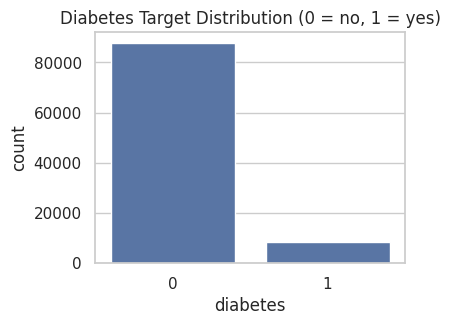

diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(4, 3))
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Target Distribution (0 = no, 1 = yes)')
plt.show()

print(df['diabetes'].value_counts(normalize=True))

### 4.2 Numeric Feature Distributions

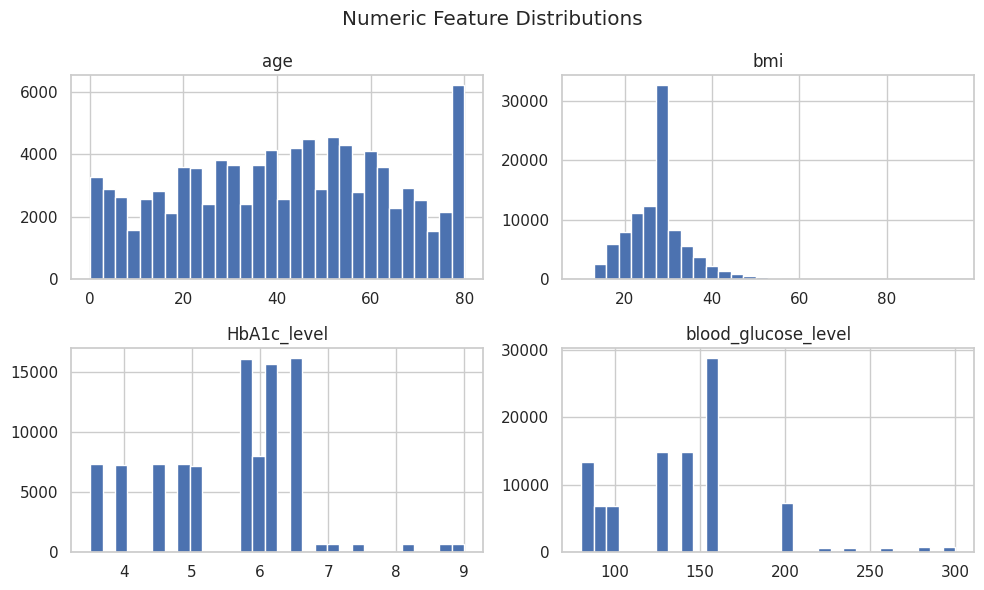

In [8]:
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
df[numeric_cols].hist(bins=30, figsize=(10, 6))
plt.suptitle('Numeric Feature Distributions')
plt.tight_layout()
plt.show()

### 4.3 Correlation Heatmap (Numeric Features + Target)

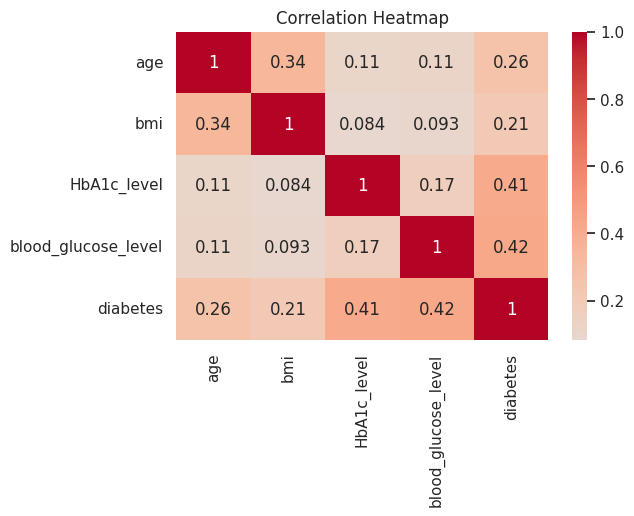

In [9]:
corr_cols = numeric_cols + ['diabetes']
corr = df[corr_cols].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

## 5. Train/Validation/Test Split and Feature Engineering

We:
- Use `diabetes` as the target
- Split into train/validation/test sets (60/20/20)
- Use `DictVectorizer` to one-hot encode categorical features and keep numeric features
- Wrap encoded arrays into XGBoost `DMatrix` objects

In [10]:
target_col = 'diabetes'
y = df[target_col].values
X = df.drop(columns=[target_col])

df_train_full, df_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

df_train, df_val, y_train, y_val = train_test_split(
    df_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print('Train:', df_train.shape, 'Val:', df_val.shape, 'Test:', df_test.shape)

# DictVectorizer for one-hot encoding
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

X_train_enc = dv.fit_transform(train_dicts)
X_val_enc = dv.transform(val_dicts)
X_test_enc = dv.transform(test_dicts)

X_train_enc.shape, X_val_enc.shape, X_test_enc.shape

Train: (57687, 8) Val: (19229, 8) Test: (19230, 8)


((57687, 15), (19229, 15), (19230, 15))

In [11]:
# Wrap into XGBoost DMatrices
dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dval = xgb.DMatrix(X_val_enc, label=y_val)
dtest = xgb.DMatrix(X_test_enc, label=y_test)

feature_names = dv.get_feature_names_out().tolist()
len(feature_names)

15

## 6. Baseline Models

We train three baseline models:
- Logistic Regression
- Random Forest
- Baseline XGBoost (with reasonable default parameters)

In [13]:
# Logistic Regression baseline
log_reg = LogisticRegression(max_iter=2000, n_jobs=-1)
log_reg.fit(X_train_enc, y_train)

# Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train_enc, y_train)

# Baseline XGBoost (no tuning)
xgb_params_baseline = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

baseline_xgb = xgb.train(
    params=xgb_params_baseline,
    dtrain=dtrain,
    num_boost_round=200,
    evals=[(dval, 'validation')],
    verbose_eval=False,
)

print('Baseline models trained.')

Baseline models trained.


## 7. Helper Evaluation Functions

We define utility functions to evaluate sklearn models and XGBoost models consistently.

In [14]:
def eval_sklearn_model(model, Xv, yv):
    proba = model.predict_proba(Xv)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        'f1': f1_score(yv, preds),
        'roc_auc': roc_auc_score(yv, proba),
        'precision': precision_score(yv, preds),
        'recall': recall_score(yv, preds),
    }

def eval_xgb_model(model, dval, yv):
    proba = model.predict(dval)
    preds = (proba >= 0.5).astype(int)
    return {
        'f1': f1_score(yv, preds),
        'roc_auc': roc_auc_score(yv, proba),
        'precision': precision_score(yv, preds),
        'recall': recall_score(yv, preds),
    }

## 8. Hyperparameter Tuning for XGBoost (using DMatrix)

We perform a simple grid search over a few key hyperparameters:
- `eta` (learning rate)
- `max_depth`
- `num_boost_round`

We use F1 score on the validation set as the primary selection metric, with ROC AUC as a secondary metric if needed.

In [15]:
from itertools import product

eta_values = [0.01, 0.1, 0.3]
depth_values = [3, 6, 10]
rounds_values = [100, 200, 400]

best_f1 = -1
best_xgb = None
best_xgb_params = None
best_metrics = None

for eta, depth, rounds in product(eta_values, depth_values, rounds_values):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': eta,
        'max_depth': depth,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=rounds,
        evals=[(dval, 'validation')],
        verbose_eval=False,
    )

    metrics = eval_xgb_model(model, dval, y_val)

    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        best_xgb = model
        best_xgb_params = {'eta': eta, 'max_depth': depth, 'num_boost_round': rounds}
        best_metrics = metrics

best_xgb_params, best_metrics

({'eta': 0.1, 'max_depth': 3, 'num_boost_round': 200},
 {'f1': 0.8074662979605945,
  'roc_auc': 0.9786983393310081,
  'precision': 0.9757727652464494,
  'recall': 0.6886792452830188})

## 9. Feature Importance Analysis (XGBoost)

We inspect feature importances from the tuned XGBoost model using the `gain` importance type and map them back to the `DictVectorizer` feature names.

In [16]:
importance_dict = best_xgb.get_score(importance_type='gain')

# XGBoost uses feature names like 'f0', 'f1', ... corresponding to columns in the DMatrix
importances = []
for fname, importance in importance_dict.items():
    idx = int(fname[1:])  # drop 'f' and convert to int
    if idx < len(feature_names):
        importances.append((feature_names[idx], importance))

fi_df = pd.DataFrame(importances, columns=['feature', 'importance']).sort_values(
    by='importance', ascending=False
)

fi_df.head(15)

,feature,importance
0,HbA1c_level,263.985168
2,blood_glucose_level,161.012939
1,age,55.642986
7,hypertension,40.287464
6,heart_disease,24.072216
3,bmi,19.239244
12,smoking_history=no info,17.105234
5,gender=male,7.696763
8,smoking_history=current,3.849925
4,gender=female,3.847710


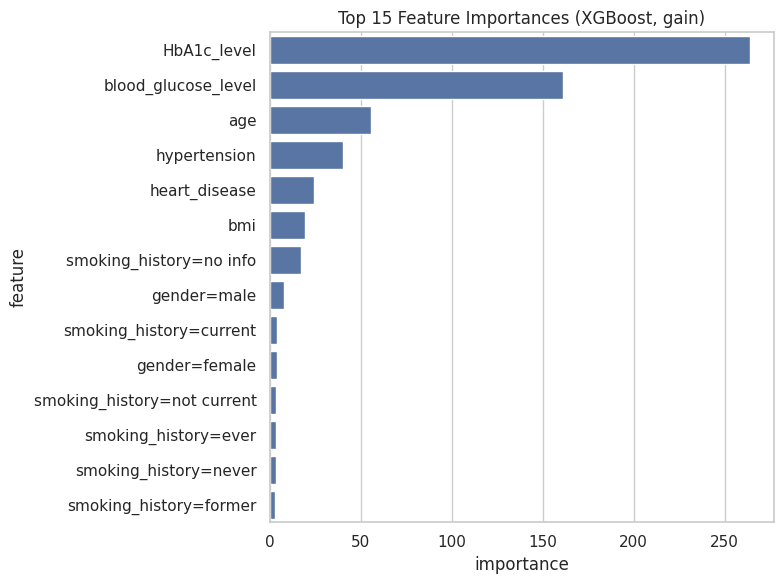

In [17]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=fi_df.head(15),
    x='importance',
    y='feature',
)
plt.title('Top 15 Feature Importances (XGBoost, gain)')
plt.tight_layout()
plt.show()

## 10. Model Comparison and Best Model Selection

We compare:
- Logistic Regression
- Random Forest
- Baseline XGBoost
- Tuned XGBoost

using F1, ROC AUC, precision, and recall on the validation set. We choose the best model by:
1. Highest F1 score
2. If tied, highest ROC AUC


In [18]:
scores = {
    'Logistic Regression': eval_sklearn_model(log_reg, X_val_enc, y_val),
    'Random Forest': eval_sklearn_model(rf, X_val_enc, y_val),
    'Baseline XGBoost': eval_xgb_model(baseline_xgb, dval, y_val),
    'Tuned XGBoost': eval_xgb_model(best_xgb, dval, y_val),
}

scores

{'Logistic Regression': {'f1': 0.7298674821610601,
  'roc_auc': 0.9601178108612438,
  'precision': 0.8612670408981555,
  'recall': 0.6332547169811321},
 'Random Forest': {'f1': 0.7899558873430608,
  'roc_auc': 0.9631032189703728,
  'precision': 0.9304556354916067,
  'recall': 0.6863207547169812},
 'Baseline XGBoost': {'f1': 0.8010880652839171,
  'roc_auc': 0.9777286382605739,
  'precision': 0.9461847389558233,
  'recall': 0.6945754716981132},
 'Tuned XGBoost': {'f1': 0.8074662979605945,
  'roc_auc': 0.9786983393310081,
  'precision': 0.9757727652464494,
  'recall': 0.6886792452830188}}

In [19]:
best_model_name = max(
    scores.keys(),
    key=lambda m: (scores[m]['f1'], scores[m]['roc_auc'])
)

print('Best model based on validation metrics:', best_model_name)
scores[best_model_name]

Best model based on validation metrics: Tuned XGBoost


{'f1': 0.8074662979605945,
 'roc_auc': 0.9786983393310081,
 'precision': 0.9757727652464494,
 'recall': 0.6886792452830188}

In [20]:
if best_model_name == 'Tuned XGBoost':
    final_model = best_xgb
elif best_model_name == 'Baseline XGBoost':
    final_model = baseline_xgb
elif best_model_name == 'Random Forest':
    final_model = rf
else:
    final_model = log_reg

final_model

## 11. Final Evaluation on Test Set

We evaluate the selected best model on the held-out test set to estimate generalisation performance.

In [21]:
if 'XGBoost' in best_model_name:
    proba_test = final_model.predict(dtest)
else:
    proba_test = final_model.predict_proba(X_test_enc)[:, 1]

preds_test = (proba_test >= 0.5).astype(int)

print('Test F1:', f1_score(y_test, preds_test))
print('Test ROC AUC:', roc_auc_score(y_test, proba_test))
print('\nClassification Report (Test Set):\n')
print(classification_report(y_test, preds_test))

Test F1: 0.8111839834311356
Test ROC AUC: 0.9779571287105806

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.98      0.69      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.97      0.85      0.90     19230
weighted avg       0.97      0.97      0.97     19230



## 12. Save Final Model

We save the best model together with the fitted `DictVectorizer` so we can preprocess new data in the same way at prediction time.

In [22]:
os.makedirs('../models', exist_ok=True)

output_path = '../models/final_diabetes_xgb_model.pkl'

with open(output_path, 'wb') as f_out:
    pickle.dump(
        {
            'dv': dv,
            'model': final_model,
            'best_model_name': best_model_name,
            'validation_scores': scores,
            'xgb_best_params': best_xgb_params,
        },
        f_out,
    )

print(f'Model saved to: {output_path}')

Model saved to: ../models/final_diabetes_xgb_model.pkl


In [ ]:
13. 